# Model training

## Import libraries

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [2]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.95, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

## Considered estimators and their parameters

Enumeration class containing all estimators we want to consider for classification and dictionary of parameters of the estimators.

In [5]:
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    forest_estimator=RandomForestClassifier()
    nn_estimator=MLPClassifier(random_state=1, max_iter=300)
    # svc_estimator=SVC(random_state=0)

# TODO JG: Adjust nn parameters
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:2}, {0:1, 1:1}],
        'n_estimators': [2, 3, 4, 5]
    },
    #Estimator.svc_estimator: {
    #    'kernel': ['linear', 'poly']
    #},
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu']
    }
}

## Methods

Evaluation method that provides evaluation for the passed model with different parameters

In [6]:
def model_eval(
        estimator,
        parameters,
        X_train,
        y_train,
        X_test,
        y_test,
        scoring=make_scorer(fbeta_score, beta=2),
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
        verbose=0
):
    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator,
                                         param_grid=parameters,
                                         scoring=scoring,
                                         cv=cv,
                                         return_train_score=False,
                                         verbose=verbose
                                         )
    # training and prediction
    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    display(grid_search_estimator.best_params_)
    display(get_scores(y_test, y_predicted))
    display(plot_roc(y_test, y_predicted))

    if estimator==Estimator.forest_estimator:
        display(plot_feature_importance(grid_search_estimator.best_estimator_))

    if estimator==Estimator.nn_estimator:
        display(plot_learning_curve(grid_search_estimator, X_test, y_test, cv, scoring))

Method that returns different scores for the passed parameters

In [7]:
def get_scores(y_test, y_predicted):
    return {'accuracy': accuracy_score(y_test, y_predicted),
            'recall': recall_score(y_test, y_predicted),
            'precision': precision_score(y_test, y_predicted),
            'f1_score': f1_score(y_test, y_predicted),
            'f2_score': fbeta_score(y_test, y_predicted, beta=2)}

Method that plots the ROC for the passed parameters

In [8]:
def plot_roc(y_test, y_predicted):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic (ROC)')

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return figure

Method that plots the feature importance for the passed parameters

In [9]:
def plot_feature_importance(estimator):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Feature Importance')
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh')
    return figure

Method that plots the learning curve for the passed parameters

In [10]:
def plot_learning_curve():
    return ""

## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

{'accuracy': 0.8402126328955597,
 'recall': 0.06204379562043796,
 'precision': 0.06273062730627306,
 'f1_score': 0.062385321100917435,
 'f2_score': 0.06217995610826628}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

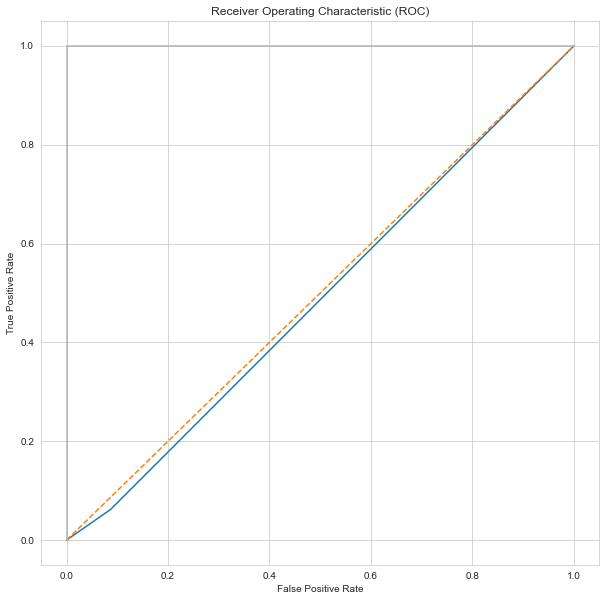

In [11]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

display(get_scores(y_test, y_predicted))
display(plot_roc(y_test, y_predicted))

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

knn_estimator


{'n_neighbors': 3}

{'accuracy': 0.9040025015634772,
 'recall': 0.14233576642335766,
 'precision': 0.35135135135135137,
 'f1_score': 0.20259740259740258,
 'f2_score': 0.16155758077879037}

<Figure size 432x288 with 0 Axes>

None

forest_estimator


{'class_weight': {0: 1, 1: 2}, 'n_estimators': 3}

{'accuracy': 0.8952470293933709,
 'recall': 0.15328467153284672,
 'precision': 0.2896551724137931,
 'f1_score': 0.20047732696897375,
 'f2_score': 0.16921837228041903}

<Figure size 432x288 with 0 Axes>

None

nn_estimator


{'activation': 'identity'}

{'accuracy': 0.9171357098186367,
 'recall': 0.24817518248175183,
 'precision': 0.5354330708661418,
 'f1_score': 0.33915211970074816,
 'f2_score': 0.27800490596892885}

<Figure size 432x288 with 0 Axes>

None

<Figure size 432x288 with 0 Axes>

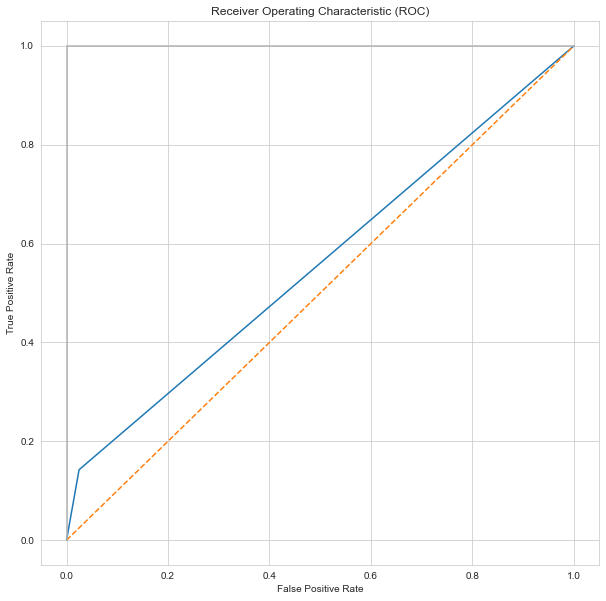

<Figure size 432x288 with 0 Axes>

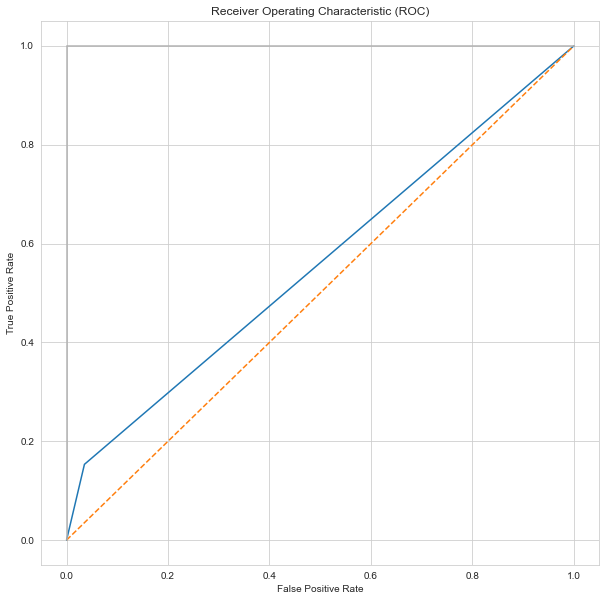

<Figure size 432x288 with 0 Axes>

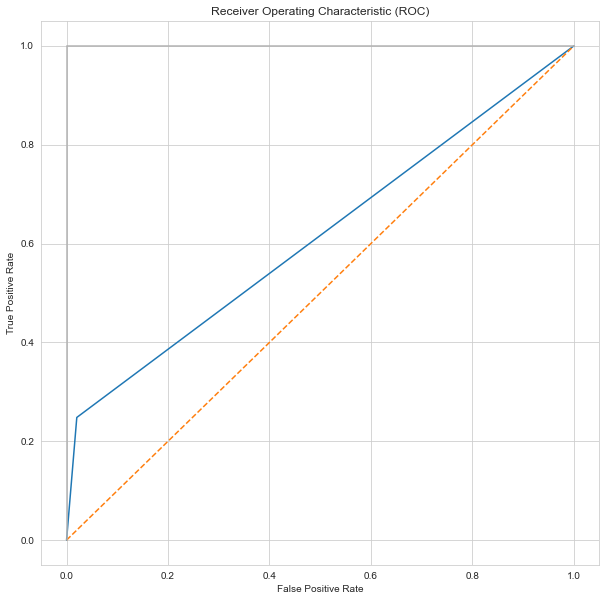

In [12]:
for estimator in Estimator:
    print(estimator.name)
    display(model_eval(estimator=estimator.value, parameters=param_grids.get(estimator), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

**Conclusion**

TODO: Add conclusion